In [1]:
! apt install tesseract-ocr
! apt install libtesseract-dev

'apt' is not recognized as an internal or external command,
operable program or batch file.
'apt' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!pip install pytesseract --user

DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [4]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [3]:
import pytesseract
from PIL import Image
import requests
from io import BytesIO
import cv2
import numpy as np

In [6]:
!ls -alrt /usr/bin/tesseract

-rwxr-xr-x 1 root root 35128 Feb  9  2022 /usr/bin/tesseract


In [5]:
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

In [6]:
#path='https://i0.wp.com/unitedrudrafoundation.com/wp-content/uploads/2019/02/personal_check_single_preprinted_blank.jpg'
#content = requests.get(path).content
#image = Image.open(BytesIO(content))

In [7]:
image = cv2.imread('f9.tif')
image

In [8]:
print(pytesseract.image_to_string(image, lang = 'eng'))

TypeError: Unsupported image object

In [14]:
!wget https://raw.githubusercontent.com/BigPino67/Tesseract-MICR-OCR/master/Tessdata/mcr.traineddata

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [15]:
!cp mcr.traineddata /usr/share/tesseract-ocr/4.00/tessdata/

'cp' is not recognized as an internal or external command,
operable program or batch file.


In [24]:
def preprocess_cheque_image(image, desired_width=1500, clip_limit=0.3, tile_grid_size=(2, 2), gaussian_kernel=(3, 3), gaussian_std=0, adaptive_threshold=False, erosion_dilation=False):
    # Load the cheque image without resizing
    # image = cv2.imread(cheque_image_path, cv2.IMREAD_UNCHANGED)

    if image is None:
        print("Error: Could not load the image.")
        return None

    # Calculate the aspect ratio
    aspect_ratio = image.shape[1] / image.shape[0]

    # Calculate the corresponding height to maintain the aspect ratio
    desired_height = int(desired_width / aspect_ratio)

    # Resize the image to the desired dimensions
    resized_image = cv2.resize(image, (desired_width, desired_height))

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # Remove shadows using CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    shadow_removal_image = clahe.apply(gray_image)

    # Apply Gaussian blur for noise reduction
    blurred_image = cv2.GaussianBlur(shadow_removal_image, gaussian_kernel, gaussian_std)

    # Apply morphological operations (erosion and dilation) if enabled
    if erosion_dilation:
        kernel = np.ones((1, 1), np.uint8)
        morph_image = cv2.morphologyEx(blurred_image, cv2.MORPH_CLOSE, kernel)
        return morph_image

    return blurred_image


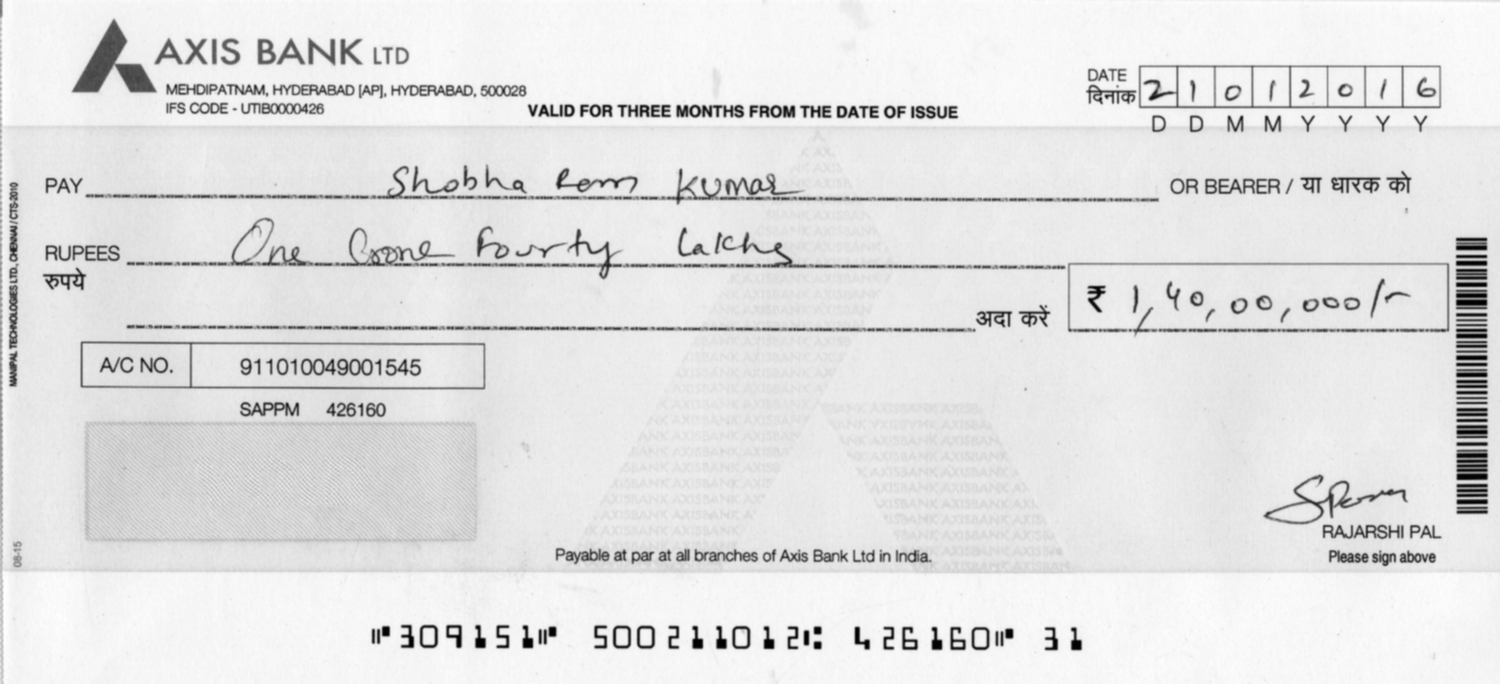

In [25]:
from google.colab.patches import cv2_imshow
preprocessed_image = preprocess_cheque_image(image)

if preprocessed_image is not None:
    # Display the preprocessed image with morphological operations
    cv2_imshow(preprocessed_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

![alt text](https://raw.githubusercontent.com/BigPino67/Tesseract-MICR-OCR/master/readmeImages/micrTable.png)

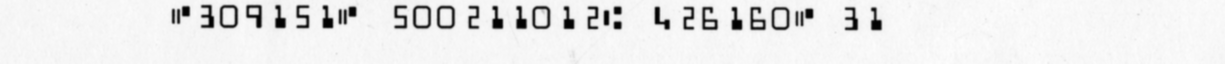

Extracted substring: 309151


In [29]:
micr_img = preprocessed_image[620:714, 200:1425]

cv2_imshow(micr_img)
input_string = pytesseract.image_to_string(micr_img,  lang = 'mcr')

mic = input_string.split('c', 2)[1] if input_string.count('c') > 1 else "Substring between 'c's not found or invalid input."
print("Extracted substring:", mic)

In [13]:
import cv2
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os

# Function to extract and preprocess the signature from a cheque image
def extract_and_process_signature(cheque_image, target_length=1000):
    # Crop the image to the specified ROI
    signature_segment = cheque_image[400:600 , 1250:1500]
    cv2_imshow(signature_segment)

    # surf = cv2.SURF_create()  # Create a SURF object
    # keypoints, descriptors = surf.detectAndCompute(image, None)  # Detect keypoints and compute descriptors
    # surf_features = descriptors.flatten() if descriptors is not None else None  # Flatten the descriptors if available
    # return surf_features
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(signature_segment, None)

    signature_features = des.flatten()

    signature_features = signature_features[:target_length]

    return signature_features

features = []
labels = []


extract_and_process_signature(preprocessed_image)

NameError: name 'preprocessed_image' is not defined

In [ ]:
text = pytesseract.image_to_string(preprocessed_image)

# Split the extracted text by space to find individual words
words = text.split()

ifs_code = None

# Search for a word that matches the pattern of IFS code (typically 11 characters)
for word in words:
    if len(word) == 11 and word.isalnum():
        ifs_code = word
        break
# Print the extracted IFS code and account number
if ifs_code:
    print("IFS Code:", ifs_code)
else:
    print("IFS Code not found in the image")

In [12]:
import os
cheque_folder = '300'
for filename in os.listdir(cheque_folder):
    if filename.endswith(".tif") or filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(cheque_folder, filename)

        # Extract and preprocess the signature
        signature_features = extract_and_process_signature(image_path)

        # Append features and label (genuine or forged) to the lists
        features.append(signature_features)
        labels.append("genuine" if "genuine" in filename else "forged")

# Print unique labels to check the classes
print("Unique Labels:", set(labels))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Initialize the SVM classifier
classifier = svm.SVC()

# Train the classifier
classifier.fit(X_train, y_train)

# Predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

NameError: name 'extract_and_process_signature' is not defined